
=== Federated Learning with FedProx ===
Running 10 rounds with 5 epochs per client
Proximal term μ: 0.01
Found 21960 images belonging to 2 classes.
Found 5490 images belonging to 2 classes.

Client 0 Data:
Training samples: 21960
Validation samples: 5490
Class distribution: {'Demented': 0, 'Non Demented': 1}
Found 21960 images belonging to 2 classes.
Found 5490 images belonging to 2 classes.

Client 1 Data:
Training samples: 21960
Validation samples: 5490
Class distribution: {'Demented': 0, 'Non Demented': 1}
Found 21960 images belonging to 2 classes.
Found 5490 images belonging to 2 classes.

Client 2 Data:
Training samples: 21960
Validation samples: 5490
Class distribution: {'Demented': 0, 'Non Demented': 1}
Found 21960 images belonging to 2 classes.
Found 5490 images belonging to 2 classes.

Client 3 Data:
Training samples: 21960
Validation samples: 5490
Class distribution: {'Demented': 0, 'Non Demented': 1}


c:\Users\musab\PycharmProjects\DataScienceGame\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Baseline - Accuracy: 0.5419, AUC: 0.7418

=== Round 1/10 ===

Client 0 Training with FedProx (μ=0.01)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 461ms/step - loss: 0.5772 - accuracy: 0.7506

Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 463ms/step - loss: 0.5032 - accuracy: 0.7869

Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 466ms/step - loss: 0.4652 - accuracy: 0.8044

Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 468ms/step - loss: 0.4620 - accuracy: 0.7906

Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 469ms/step - loss: 0.4532 - accuracy: 0.7937

Client 1 Training with FedProx (μ=0.01)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 467ms/step - loss: 0.5667 - accuracy: 0.7512

Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 466ms/step - loss: 0.4744 - accuracy: 0.8000

Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 465ms/step - loss: 0.4912 - accuracy: 0.7869

Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 466ms/step - loss: 0.4905 - accuracy: 0.7906

Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 468ms/step - loss: 0.4687 - acc

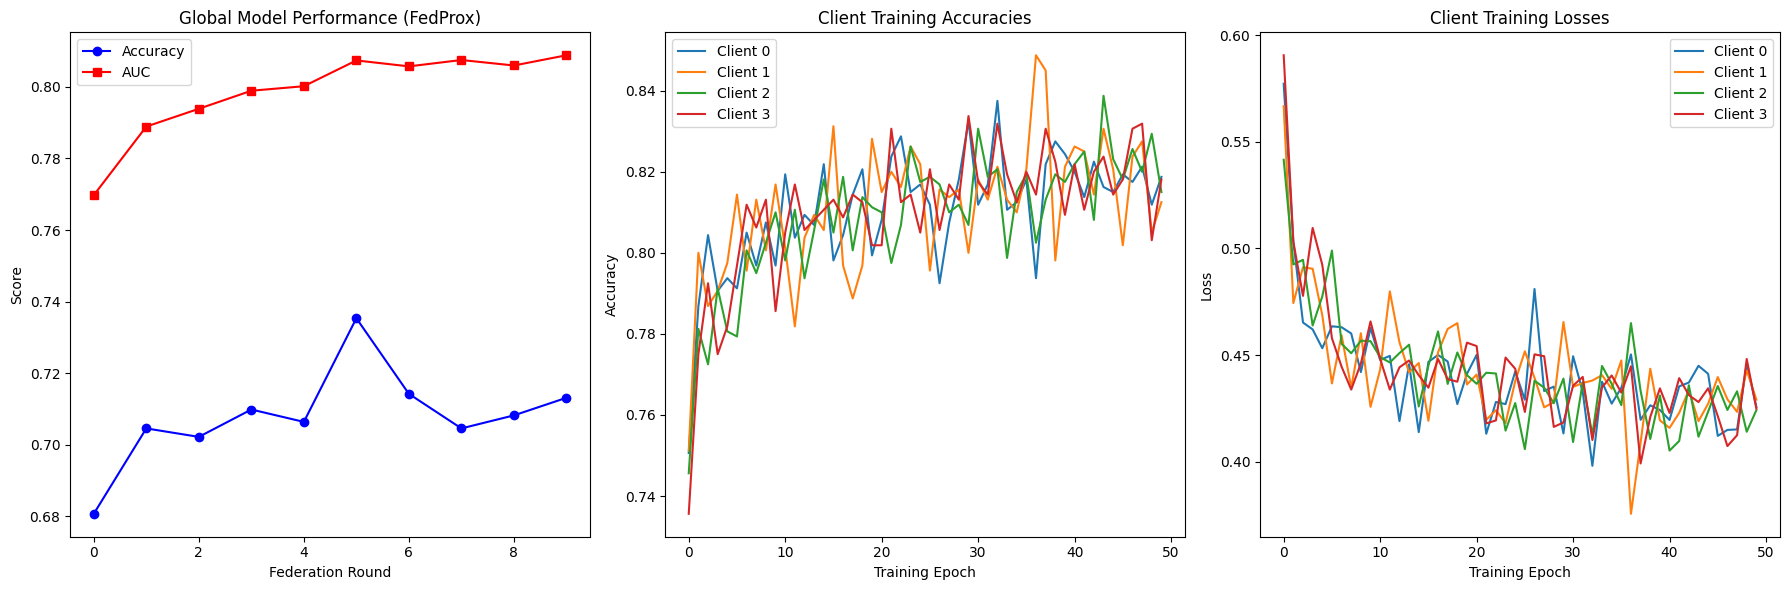


=== Final FedProx Model Evaluation ===
Model ready for deployment with:
- 10 federation rounds
- 5 epochs per client
- 4 participating clients
- FedProx μ parameter: 0.01


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Progbar
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
import gc

# Configuration
DATA_PATH = "C:/Users/musab/PycharmProjects/DataScienceGame/LOHITH_NEW/archive/Data"
CENTRAL_MODEL_PATH = "central_alzheimer_model(new).keras"
NUM_CLIENTS = 4
ROUNDS = 10
CLIENT_EPOCHS = 5
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)
LEARNING_RATE = 0.0001
STEPS_PER_EPOCH = 50
FEDPROX_MU = 0.01  # Proximal term weight (μ)

def create_client_datasets():
    """Create client datasets with enhanced augmentation"""
    clients = []
    for client_id in range(NUM_CLIENTS):
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.8, 1.2],
            validation_split=0.2
        )
        
        train_gen = train_datagen.flow_from_directory(
            DATA_PATH,
            target_size=TARGET_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='binary',
            subset='training',
            shuffle=True,
            seed=42 + client_id
        )
        
        val_gen = train_datagen.flow_from_directory(
            DATA_PATH,
            target_size=TARGET_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='binary',
            subset='validation',
            shuffle=False,
            seed=42
        )
        
        print(f"\nClient {client_id} Data:")
        print(f"Training samples: {train_gen.samples}")
        print(f"Validation samples: {val_gen.samples}")
        print(f"Class distribution: {train_gen.class_indices}")
        
        clients.append({
            'train': train_gen,
            'val': val_gen,
            'train_steps': len(train_gen),
            'val_steps': len(val_gen)
        })
    return clients

def prepare_global_model():
    """Load and enhance existing central model"""
    global_model = load_model(CENTRAL_MODEL_PATH)
    
    # Architecture adaptation with enhanced layer
    if not any(isinstance(layer, GlobalAveragePooling2D) for layer in global_model.layers):
        print("Enhancing model architecture...")
        base_model = Model(inputs=global_model.inputs, 
                         outputs=global_model.layers[-2].output)
        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(128, activation='relu')(x)  # Added dense layer
        predictions = Dense(1, activation='sigmoid')(x)
        global_model = Model(inputs=base_model.input, outputs=predictions)
    
    global_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return global_model

def fedprox_loss(y_true, y_pred, model_weights, global_weights, mu=FEDPROX_MU):
    """Calculate FedProx loss with proximal term"""
    # Standard binary crossentropy
    base_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))
    
    # Proximal term (L2 difference between local and global weights)
    proximal_term = 0.0
    for w, gw in zip(model_weights, global_weights):
        proximal_term += tf.reduce_sum(tf.square(w - gw))
    
    return base_loss + (mu / 2) * proximal_term

def train_client_with_fedprox(client_data, global_model, client_id, epochs=CLIENT_EPOCHS):
    """Train a client model with FedProx optimization"""
    # Clone the global model
    local_model = tf.keras.models.clone_model(global_model)
    local_model.set_weights(global_model.get_weights())
    
    # Get global weights for proximal term
    global_weights = global_model.get_weights()
    
    # Create optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    
    # Metrics tracking
    train_loss = []
    train_accuracy = []
    
    print(f"\nClient {client_id} Training with FedProx (μ={FEDPROX_MU})")
    
    # Calculate total steps
    total_steps = min(STEPS_PER_EPOCH, client_data['train_steps'])
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Initialize metrics
        epoch_loss = []
        epoch_accuracy = []
        
        # Create progress bar
        progress_bar = Progbar(total_steps, stateful_metrics=['loss', 'accuracy'])
        
        for step, (images, labels) in enumerate(client_data['train']):
            if step >= total_steps:
                break
                
            # Ensure proper shapes
            labels = tf.reshape(labels, (-1, 1))
            
            with tf.GradientTape() as tape:
                predictions = local_model(images, training=True)
                loss = fedprox_loss(
                    labels,
                    predictions, 
                    local_model.trainable_weights,
                    global_weights
                )
                # Calculate accuracy
                acc = tf.reduce_mean(tf.keras.metrics.binary_accuracy(labels, predictions))
            
            gradients = tape.gradient(loss, local_model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, local_model.trainable_variables))
            
            # Store metrics
            epoch_loss.append(loss.numpy().item())  # Convert to Python scalar
            epoch_accuracy.append(acc.numpy().item())  # Convert to Python scalar
            
            # Update progress bar
            progress_bar.update(
                step + 1,
                values=[
                    ('loss', np.mean(epoch_loss)),
                    ('accuracy', np.mean(epoch_accuracy))
                ]
            )
        
        # Store epoch metrics
        train_loss.append(np.mean(epoch_loss))
        train_accuracy.append(np.mean(epoch_accuracy))
    
    return local_model.get_weights(), client_data['train'].samples, train_loss, train_accuracy

def federated_training_with_fedprox():
    print("\n=== Federated Learning with FedProx ===")
    print(f"Running {ROUNDS} rounds with {CLIENT_EPOCHS} epochs per client")
    print(f"Proximal term μ: {FEDPROX_MU}")
    
    clients = create_client_datasets()
    global_model = prepare_global_model()
    
    # Enhanced tracking
    history = {
        'round': [],
        'val_accuracy': [],
        'val_auc': [],
        'client_losses': [[] for _ in range(NUM_CLIENTS)],
        'client_accuracies': [[] for _ in range(NUM_CLIENTS)]
    }
    
    # Baseline evaluation
    baseline_val = global_model.evaluate(clients[0]['val'], verbose=0)
    print(f"\nBaseline - Accuracy: {baseline_val[1]:.4f}, AUC: {baseline_val[2]:.4f}")
    
    for round_num in range(ROUNDS):
        print(f"\n=== Round {round_num+1}/{ROUNDS} ===")
        client_weights = []
        client_samples = []
        
        # Client training with FedProx
        for client_id in range(NUM_CLIENTS):
            weights, samples, losses, accuracies = train_client_with_fedprox(
                clients[client_id], 
                global_model,
                client_id
            )
            client_weights.append(weights)
            client_samples.append(samples)
            
            # Store client metrics
            history['client_losses'][client_id].extend(losses)
            history['client_accuracies'][client_id].extend(accuracies)
        
        # Weighted averaging (FedAvg)
        avg_weights = []
        for i in range(len(client_weights[0])):
            layer_weights = np.array([weights[i] for weights in client_weights])
            avg_weights.append(np.average(
                layer_weights,
                axis=0,
                weights=client_samples
            ))
        
        global_model.set_weights(avg_weights)
        
        # Comprehensive evaluation
        val_results = global_model.evaluate(clients[0]['val'], verbose=0)
        history['round'].append(round_num)
        history['val_accuracy'].append(val_results[1])
        history['val_auc'].append(val_results[2])
        
        print(f"\nRound {round_num+1} Results:")
        print(f"Validation Accuracy: {val_results[1]:.4f}")
        print(f"Validation AUC: {val_results[2]:.4f}")
        
        # Periodic full evaluation
        if (round_num+1) % 5 == 0:  # Every 5 rounds
            val_gen = clients[0]['val']
            val_gen.reset()
            y_pred = (global_model.predict(val_gen, verbose=0) > 0.5).astype(int)
            print("\nDetailed Classification Report:")
            print(classification_report(val_gen.labels, y_pred, 
                                      target_names=val_gen.class_indices.keys()))
    
    # Save final model
    global_model.save('alzheimer_model_fedprox_4Clients.keras')
    print("\nSaved FedProx model as 'alzheimer_model_fedprox_4Clients.keras'")
    
    # Visualization
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['round'], history['val_accuracy'], 'b-o', label='Accuracy')
    plt.plot(history['round'], history['val_auc'], 'r-s', label='AUC')
    plt.title('Global Model Performance (FedProx)')
    plt.xlabel('Federation Round')
    plt.ylabel('Score')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    for client_id in range(NUM_CLIENTS):
        plt.plot(range(len(history['client_accuracies'][client_id])), 
                history['client_accuracies'][client_id], 
                label=f'Client {client_id}')
    plt.title('Client Training Accuracies')
    plt.xlabel('Training Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    for client_id in range(NUM_CLIENTS):
        plt.plot(range(len(history['client_losses'][client_id])), 
                history['client_losses'][client_id],
                label=f'Client {client_id}')
    plt.title('Client Training Losses')
    plt.xlabel('Training Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('fedprox_training_progress.png', dpi=300)
    plt.show()
    
    return global_model

if __name__ == "__main__":
    # Run federated training with FedProx
    final_model = federated_training_with_fedprox()
    
    # Final evaluation
    print("\n=== Final FedProx Model Evaluation ===")
    print("Model ready for deployment with:")
    print(f"- {ROUNDS} federation rounds")
    print(f"- {CLIENT_EPOCHS} epochs per client")
    print(f"- {NUM_CLIENTS} participating clients")
    print(f"- FedProx μ parameter: {FEDPROX_MU}")

📦 Loading model...
✅ Model loaded!
Found 5490 images belonging to 2 classes.
🔍 Predicting...


c:\Users\musab\PycharmProjects\DataScienceGame\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\musab\PycharmProjects\DataScienceGame\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step

📊 Classification Report:
              precision    recall  f1-score   support

    Demented       0.76      0.90      0.82      2745
Non Demented       0.88      0.71      0.78      2745

    accuracy                           0.81      5490
   macro avg       0.82      0.81      0.80      5490
weighted avg       0.82      0.81      0.80      5490


📈 ROC AUC Score: 0.869255642814722


C:\Users\musab\AppData\Local\Temp\ipykernel_36524\2541555759.py:73: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\musab\PycharmProjects\DataScienceGame\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


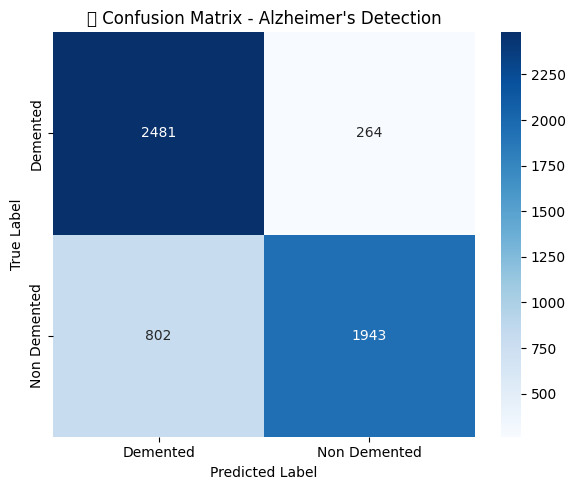

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# Configs
# ===============================
MODEL_PATH = "alzheimer_model_fedprox_4Clients.keras"
DATA_PATH = "C:/Users/musab/PycharmProjects/DataScienceGame/LOHITH_NEW/archive/Data"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42  # For reproducibility

# ===============================
# 1. Load the model
# ===============================
print("📦 Loading model...")
model = load_model(MODEL_PATH)

# (Optional but recommended) Recompile to restore metrics if needed
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
print("✅ Model loaded!")

# ===============================
# 2. Prepare validation data
# ===============================
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_gen = datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,   # Important for correct prediction-label alignment
    seed=SEED
)

# ===============================
# 3. Make predictions
# ===============================
print("🔍 Predicting...")
pred_probs = model.predict(val_gen)
preds = (pred_probs > 0.5).astype(int).flatten()
y_true = val_gen.classes

# ===============================
# 4. Evaluation Metrics
# ===============================
print("\n📊 Classification Report:")
print(classification_report(y_true, preds, target_names=list(val_gen.class_indices.keys())))

print("\n📈 ROC AUC Score:", roc_auc_score(y_true, pred_probs))

# ===============================
# 5. Confusion Matrix
# ===============================
cm = confusion_matrix(y_true, preds)
labels = list(val_gen.class_indices.keys())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("🧠 Confusion Matrix - Alzheimer's Detection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
